Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
!pip install Augmentor

In [2]:
#Importing necessary libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers,regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

import Augmentor
import glob
warnings.filterwarnings('ignore')

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

## Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Defining the path for train and test images
## Paths of train and test dataset on Google drive

data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

## Paths of train and test dataset on local machine
# data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
# data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training' )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(180, 180),
    shuffle=False,
    seed=123,
    validation_split=0.2,
    subset='validation' )

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

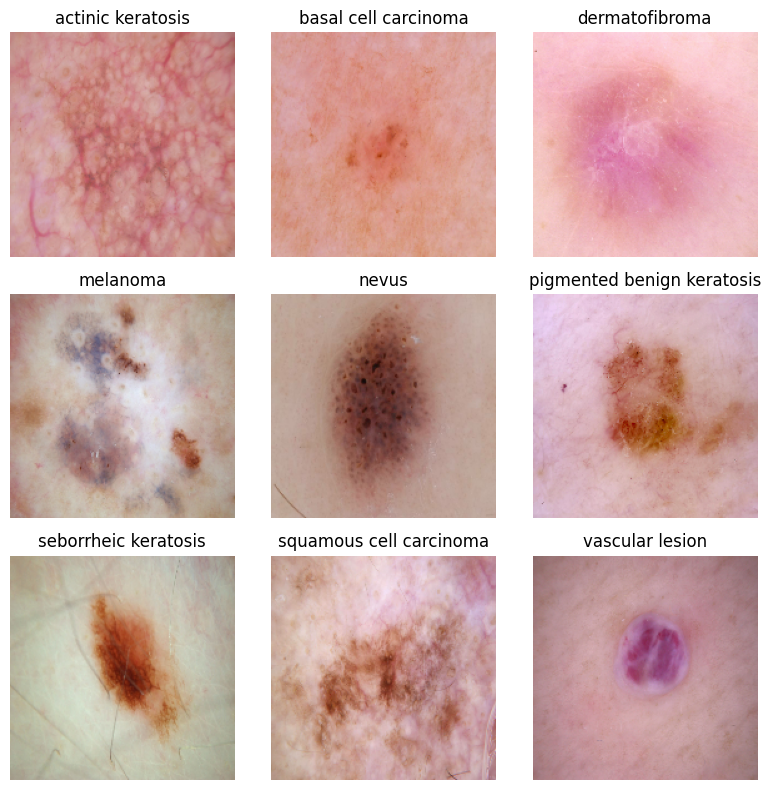

In [9]:
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(8, 8))
for i in range(len(class_names)):
    for images, labels in train_ds:
        if i in labels:
            image = images[labels == i][0]
            break
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")
plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
#Before creating the model, Its good to rescale the dataset
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
#Model
num_classes = 9
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,612,553 (231.22 MB)

 Trainable params: 60,612,553 (231.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 238ms/step - accuracy: 0.2408 - loss: 4.3388 - val_accuracy: 0.0870 - val_loss: 3.1446
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4544 - loss: 1.5585 - val_accuracy: 0.1304 - val_loss: 3.0670
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5228 - loss: 1.3746 - val_accuracy: 0.1304 - val_loss: 3.1527
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5620 - loss: 1.2357 - val_accuracy: 0.0870 - val_loss: 3.6463
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6308 - loss: 1.0870 - val_accuracy: 0.1739 - val_loss: 3.3146
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6769 - loss: 0.8974 - val_accuracy: 0.0870 - val_loss: 4.0314
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6941 - loss: 0.8358 - val_accuracy: 0.1739 - val_loss: 5.0534
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7816 - loss: 0.6505 - val_accuracy: 0.3478 -

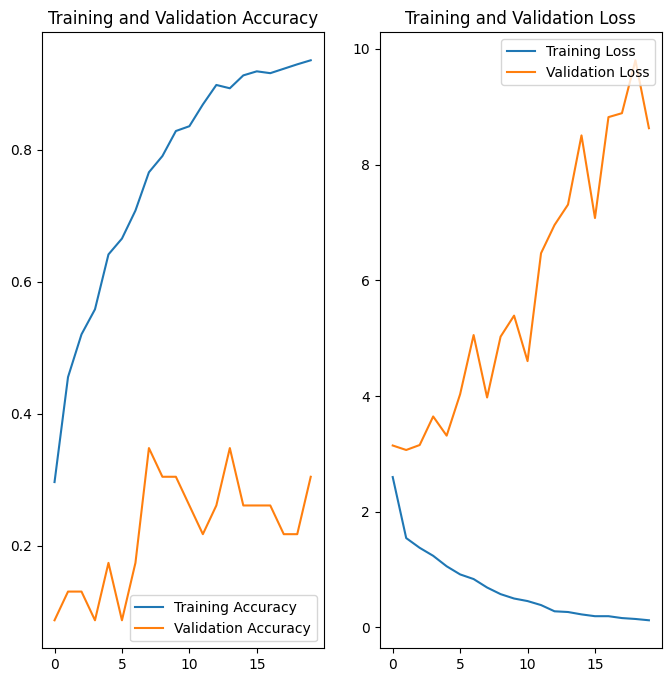

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

#### The training accuracy is steadily increasing, which indicates that the model is learning and fitting well to the training data.
#### The validation accuracy is fluctuating and remains relatively low, suggesting that the model is not generalizing well to unseen data.
#### The training loss remains very low (almost zero), further confirming that the model is fitting very well to the training data.
#### The validation loss is significantly higher and increasing over time, indicating poor performance on the validation set.
#### This indicates overfitting of the data.

In [16]:
#Choosing the appropriate augumentation strategy
#Flipping, Rotation and Zoom
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

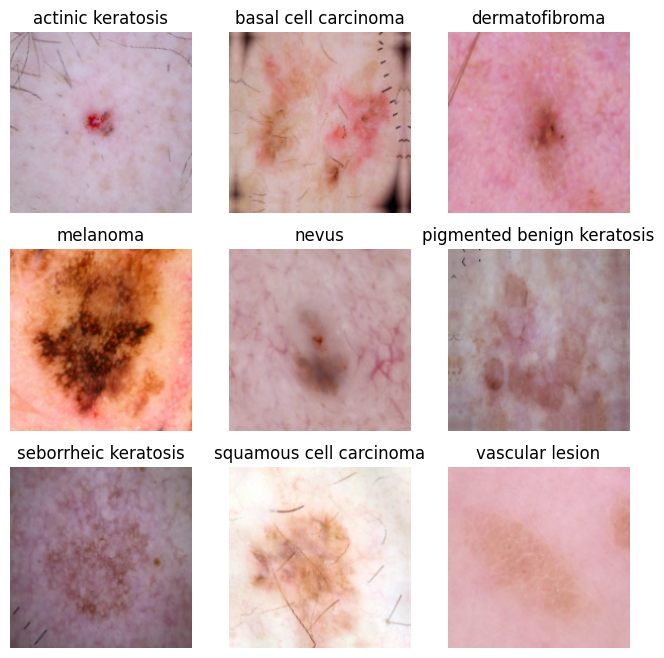

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(8, 8))
for i in range(len(class_names)):
    for images, labels in augmented_train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            plt.title(class_names[i])
            plt.axis("off")
plt.show()

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
#Model using droupouts
train_ds = augmented_train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

dp_model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),  # Adding dropout after flattening
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Adding dropout after dense layer
    layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [19]:
## Your code goes here
dp_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
dp_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,612,553 (231.22 MB)

 Trainable params: 60,612,553 (231.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = dp_model.fit(
  augmented_train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.1898 - loss: 4.4642 - val_accuracy: 0.0000e+00 - val_loss: 3.7665
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 254ms/step - accuracy: 0.2831 - loss: 1.8881 - val_accuracy: 0.0000e+00 - val_loss: 11.2645
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.3540 - loss: 1.7890 - val_accuracy: 0.0000e+00 - val_loss: 29.9594
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 254ms/step - accuracy: 0.4239 - loss: 1.6030 - val_accuracy: 0.0000e+00 - val_loss: 41.1237
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - accuracy: 0.4082 - loss: 1.6285 - val_accuracy: 0.0000e+00 - val_loss: 42.9598
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.4545 - loss: 1.5643 - val_accuracy: 0.0000e+00 - val_loss: 67.4223
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.4647 - loss: 1.4735 - val_accuracy: 0.0000e+00 - val_loss: 77.6049
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step - accuracy

### Visualizing the results

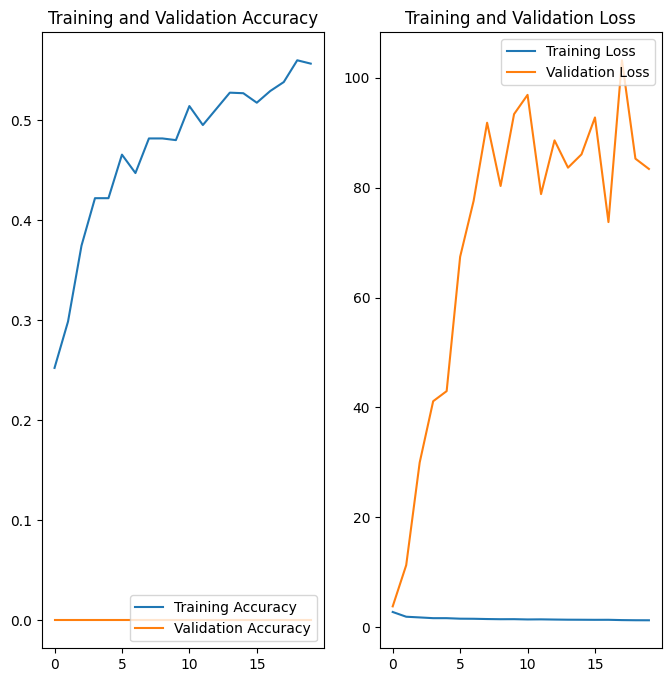

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model still overfits even after we add droupouts and augumented the data.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
## Your code goes here.
def count_files(folder_path):
    total_files = 0
    for dirpath, _, filenames in os.walk(folder_path):
        total_files += len(filenames)
    return total_files

for folder in os.listdir(data_dir_train):
    folder_path = os.path.join(data_dir_train, folder)
    if os.path.isdir(folder_path):
        # Count files in the folder and its subdirectories
        num_files = count_files(folder_path)
        print(f"Folder '{folder}' has {num_files} files.")

Folder 'actinic keratosis' has 114 files.
Folder 'basal cell carcinoma' has 376 files.
Folder 'dermatofibroma' has 95 files.
Folder 'pigmented benign keratosis' has 462 files.
Folder 'squamous cell carcinoma' has 181 files.
Folder 'vascular lesion' has 139 files.
Folder 'melanoma' has 438 files.
Folder 'nevus' has 357 files.
Folder 'seborrheic keratosis' has 77 files.


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### ANS: The class 'seborrheic keratosis' has the least number of data.
#### - Which classes dominate the data in terms proportionate number of samples?
#### ANS :The classes 'melanoma' and 'pigmented benign keratosis' has relatively more data (It dominates the dataset).

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D70A0FBA8D0>: 100%|██████████| 500/500 [00:19<00:00, 25.68 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D70A0844C90>: 100%|██████████| 500/500 [00:19<00:00, 25.62 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D70A0F9B650>: 100%|██████████| 500/500 [00:19<00:00, 25.15 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D70A0E5BED0>: 100%|██████████| 500/500 [01:27<00:00,  5.72 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7D70A0E2AF50>: 100%|██████████| 500/500 [01:20<00:00,  6.23 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D70C02A7E50>: 100%|██████████| 500/500 [00:21<00:00, 23.52 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D708FF10110>: 100%|██████████| 500/500 [00:44<00:00, 11.30 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D70C0179DD0>: 100%|██████████| 500/500 [00:19<00:00, 25.98 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D70C2B429D0>: 100%|██████████| 500/500 [00:19<00:00, 26.28 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob.glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob.glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [28]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026525.jpg', 'actinic keratosis'), ('/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025825.jpg', 'actinic keratosis'), ('/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025953.jpg', 'actinic keratosis'), ('/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026149.jpg', 'actinic keratosis'), ('/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025803.jpg', 'actinic keratosis')]


In [29]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
1,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
2,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
3,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
4,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis


In [30]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


In [31]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_ead178c9-23d8-4fba-a32a-2d1e8c8dee08.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_dada0435-96f7-4dd8-9284-64e4cfbfc9b9.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028370.jpg_813c6d07-ef28-4206-be83-34bf170aac70.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030408.jpg_a16df73b-6a7a-4a49-91a9-9e4df17c11ce.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026857.jpg_76cd9e54

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [33]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Image Path', 'Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(6739, 2)

In [35]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training & validation dataset

In [37]:
#Loading the dataset again
#Training Data
train_ds_aug = image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training' )

#Validation Data
test_ds_aug = image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(180, 180),
    shuffle=False,
    seed=123,
    validation_split=0.2,
    subset='validation' )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [38]:
#Data caching and prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_aug = train_ds_aug.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
test_ds_aug = test_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [39]:
## your code goes here
#Before creating the model, Its good to rescale the dataset
normalization_layer = layers.Rescaling(1./255)
train_ds_aug = train_ds_aug.map(lambda x, y: (normalization_layer(x), y))
test_ds_aug = test_ds_aug.map(lambda x, y: (normalization_layer(x), y))
#Model using droupouts and batch normalization
dp_model_new = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(0.6),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.6),

    layers.Dense(num_classes, activation='softmax')
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [40]:
## your code goes here
# Compile the model
dp_model_new.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
# View the summary of all layers
dp_model_new.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,614,985 (231.23 MB)

 Trainable params: 60,613,769 (231.22 MB)

 Non-trainable params: 1,216 (4.75 KB)

#### **Todo:**  Train your model

In [46]:
epochs = 30
## Your code goes here.
history = dp_model_new.fit(
  train_ds_aug,
  validation_data=test_ds_aug,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 95ms/step - accuracy: 0.3218 - loss: 5.0519 - val_accuracy: 0.0000e+00 - val_loss: 4.8623
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5251 - loss: 4.2545 - val_accuracy: 0.0000e+00 - val_loss: 5.1173
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.6213 - loss: 4.0981 - val_accuracy: 0.0000e+00 - val_loss: 6.7191
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.7144 - loss: 4.4406 - val_accuracy: 0.1739 - val_loss: 9.4818
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.7512 - loss: 4.7193 - val_accuracy: 0.1739 - val_loss: 8.5281
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.7990 - loss: 4.8436 - val_accuracy: 0.0870 - val_loss: 8.9757
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8066 - loss: 5.1440 - val_accuracy: 0.3913 - val_loss: 8.9312
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8300 - loss: 

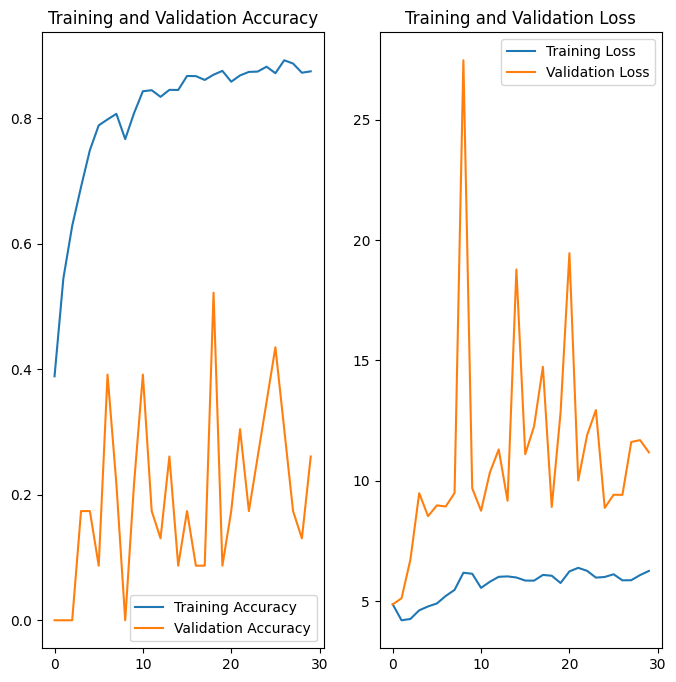

In [47]:
#plot the graphs for results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



#### Now we can see that the validation accuracy went far more better than the other two models even it overfits. But Adding more data for reducing class imbalance makes the model better.